# Нейросетевая классификация текстов

В проекте мы решим задачу классификации текстов. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Dict
import string

import seaborn
seaborn.set(palette='summer')

import gc

In [2]:
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/ded/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

## Подготовка данных

Выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
def collate_fn_with_padding(
    input_batch: List[Dict],
    pad_id:int = word2ind['<pad>'],
    max_len:int = 256
    ) -> Dict[str, torch.Tensor]:
    """
    Объединение минибатча примеров и выравнивание длин последовательностей.
    
    :param input_batch: Минибатч объектов данных (список словарей).
    :param pad_id: ID токена заполнения (<pad>).
    :param max_len: Максимальная длина последовательности.
    :return: Сформированный минибатч с выровненными последовательностями.
    """
    # Определяем длины каждой последовательности
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)
    
    # Выравниваем каждую последовательность до максимальной длины
    new_batch = []
    for sequence in input_batch:
        # Обрезаем или дополняем последовательность до заданной длины
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
        
    # Преобразование в PyTorch Tensor
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [34]:
def train(num_epoch, model) -> List:
    
    eval_steps = len(train_dataloader) // 2
    
    losses_type = {}
    acc_type = {}
    # best_model = model.state_dict() # сохраняем все тензоры модели
    # best_acc = 0.0 # для понимания лучшего скора модели
    
    for aggregation_type in ['max', 'mean']:
        print(f"Starting training for {aggregation_type}")
        losses = []
        acc = []
    
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.99))
        # sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
        for epoch in tqdm(range(num_epoch), desc=f'Training epoch {num_epoch}:'):
            epoch_losses = []
            model.train()
            for i, batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()
                # sheduler.step()
    
                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model.eval()
                    acc.append(evaluate(model, eval_dataloader))
                    model.train()
                # model.eval()
                # val_acc = evaluate(model, eval_dataloader)
                # acc.append(val_acc)
                # model.train()

                # if val_acc > best_acc:
                #     best_acc = val_acc
                #     best_model = model.state_dict()
    
            losses.append(sum(epoch_losses) / len(epoch_losses))
    
        losses_type[aggregation_type] = losses
        acc_type[aggregation_type] = acc

    # model.load_state_dict(best_model)
    return losses_type, acc_type

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """"
    Оценивает точность модели на проверочных данных.

    Параметры:
        model: Объект модели (torch.nn.Module), которую нужно оценить.
        eval_dataloader: Датеалодер проверки (DataLoader), содержащий тестовые данные.

    Возвращаемое значение:
        Точность модели (accuracy): доля верных предсказаний среди общего числа образцов.
    """
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [10]:
def clear_vram():
    '''
    Функция очистки памяти видеоадаптера
    '''
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
def plot_metrics(metrics: List, metrics_type: str):
    
        

    if metrics_type == 'Losses':
        for (name, values), color in zip(metrics.items(), ['red', 'blue']):
            plt.plot(np.arange(len(metrics[name])), metrics[name], color=color, label=name)
        plt.title('Losses')
    else:
        for (name, values), color in zip(metrics.items(), ['red', 'blue']):
            plt.plot(np.arange(len(metrics[name][1:])), metrics[name][1:], color=color, label=name)
            print(f"Лучшая accuracy для подхода {name}: {(max(metrics[name]) * 100):.2f}")
        plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [12]:
class WordDataset:
    '''
    Этот класс предназначен для обработки текста и преобразования предложений в
    токены с добавлением специальных символов начала (<bos>), конца (<eos>), пустых
    позиций (<pad>) и неизвестных слов (<unk>).
    '''
    def __init__(self, sentences: List[Dict[str, any]]) -> None:
        """
        Инициализирует объект набора данных.
        
        :param sentences: Список словарей с ключами 'text' и 'label'.
                         Каждый словарь представляет одно предложение.
        """
        # Сохраняем исходные данные
        self.data = sentences
        # Идентификаторы специальных токенов
        self.unk_id = word2ind['<unk>']   # Неизвестное слово
        self.bos_id = word2ind['<bos>']   # Начало предложения
        self.eos_id = word2ind['<eos>']   # Конец предложения
        self.pad_id = word2ind['<pad>']   # Заполнитель пустых позиций

    def __getitem__(self, idx: int) -> Dict[str, list or int]:
        """
        Возвращает элемент по индексу idx.
        
        :param idx: Индекс элемента в наборе данных.
        :return: Словарь с полями 'text' (токенизированное предложение) и 'label'
                ('текст' преобразован в список индексов слов).
        """
        # Преобразуем текст в нижний регистр и удаляем знаки препинания
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation)
        )
        # Получаем текстовую строку и её метку
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        """Возвращает количество элементов в наборе данных."""
        return len(self.data)

In [13]:
class CharLM(nn.Module):
    """"
    Класс модели классификации.

    Параметры:
        model: Объект модели (torch.nn.Module), которую нужно дополнить.
        Дополняем модель, тут RNN с классификационным слоем.
    Возвращаемое значение:
        Предсказанное значение в зависимости от числа классов.
    """
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [14]:
class CharGRU(nn.Module):
    """"
    Класс модели классификации.

    Параметры:
        model: Объект модели (torch.nn.Module), которую нужно дополнить.
        Дополняем модель, тут GRU с классификационным слоем.
    Возвращаемое значение:
        Предсказанное значение в зависимости от числа классов.
    """
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [15]:
class CharGRUx2(nn.Module):
    """"
    Класс модели классификации.

    Параметры:
        model: Объект модели (torch.nn.Module), которую нужно дополнить.
        Дополняем модель, тут двухслойная GRU с классификационным слоем.
    Возвращаемое значение:
        Предсказанное значение в зависимости от числа классов.
    """
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [16]:
class CharLMx2(nn.Module):
    """"
    Класс модели классификации.

    Параметры:
        model: Объект модели (torch.nn.Module), которую нужно дополнить.
        Дополняем модель, тут двухслойная bidirectional RNN
        с классификационным слоем.
    Возвращаемое значение:
        Предсказанное значение в зависимости от числа классов.
    """
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [17]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Наша задача -- получить максимальное возможное accuracy на `eval_dataloader`.

## Ход работы
Разобьем задачу на несколько частей:

### Запуск базовой модели
Мы создаем модель, которая дает на нашей задаче довольно высокое качество. Вычисляем ее `score`, который затем можно будет использовать в качестве бейзлайна. 

### Проведение экспериментов по улучшению модели
Чтобы улучшить качество базовой модели, попробуем различные идеи экспериментов.
нно из изменений дало прирост к качеству. 

### Сравнение полученных результатов
В конце проекта сравним полученные скоры их проведенных экспериментов

In [18]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)

In [23]:
losses_type, acc_type = train(num_epoch=10, model=model)

Starting training for max


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

Starting training for mean


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

#### Отрисуем график loss

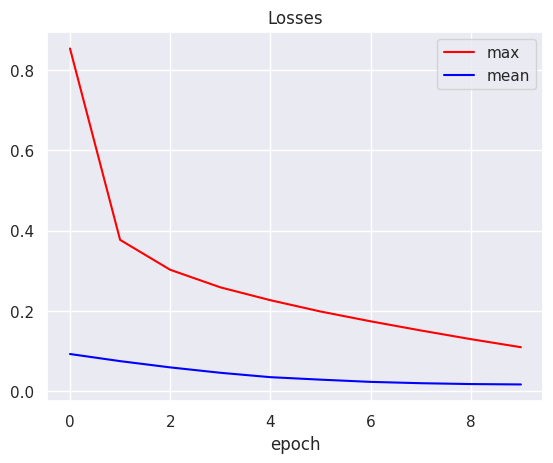

In [24]:
plot_metrics(losses_type, 'Losses')

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 89.66
Лучшая accuracy для подхода mean: 89.12


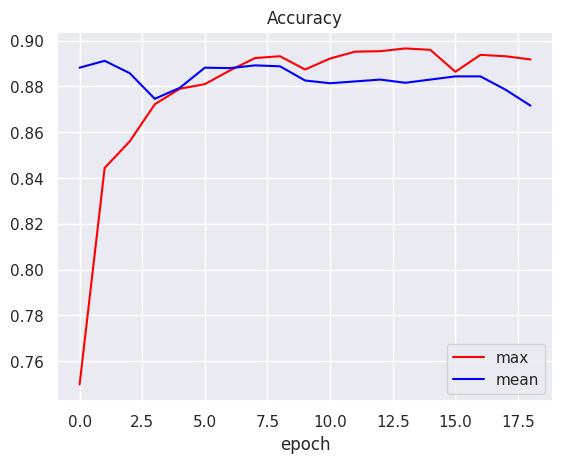

In [25]:
plot_metrics(acc_type, 'Accuracy')

In [26]:
results = pd.DataFrame({
    'Model': 'CharLM',
    'Train_Accuracy_Mean': max(acc_type['mean']),
    'Train_Accuracy_Max': max(acc_type['max']),
    'Accuracy_score': [float(evaluate(model, eval_dataloader))]
})
results

,Model,Train_Accuracy_Mean,Train_Accuracy_Max,Accuracy_score
0,CharLM,0.8912,0.8966,0.883


In [27]:
torch.save(model.state_dict(), 'model_CharLM.pth')

In [28]:
del model

In [29]:
results.to_csv('results.csv')

### Проведение экспериментов по улучшению модели

### Попробуем модель GRU

In [36]:
clear_vram()

In [37]:
model = CharGRU(
    hidden_dim=256,
    vocab_size=len(vocab)
    ).to(device)

In [38]:
losses_type, acc_type = train(num_epoch=10, model=model)

Starting training for max


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

Starting training for mean


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

#### Отрисуем график loss

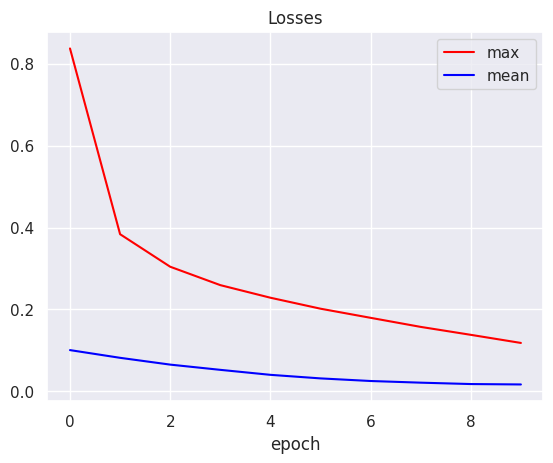

In [39]:
plot_metrics(losses_type, 'Losses')

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 89.96
Лучшая accuracy для подхода mean: 90.20


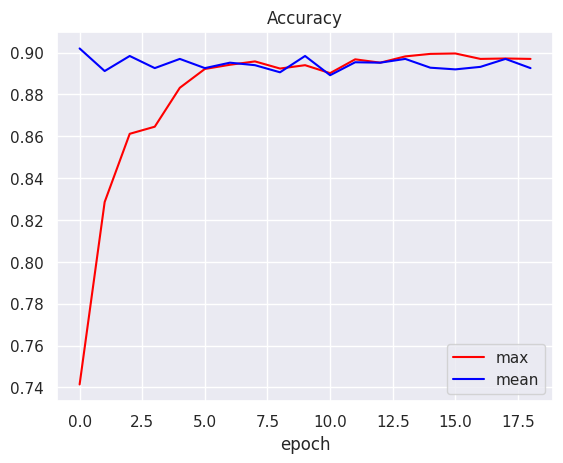

In [40]:
plot_metrics(acc_type, 'Accuracy')

In [41]:
torch.save(model.state_dict(), 'model_CharGRU.pth')

In [44]:
results.loc[1] = [
    'CharGRU', max(acc_type['mean']),
                   max(acc_type['max']),
                       float(evaluate(model, eval_dataloader))]
results

,Model,Train_Accuracy_Mean,Train_Accuracy_Max,Accuracy_score
0,CharLM,0.8912,0.8966,0.8830
1,CharGRU,0.9020,0.8996,0.8986


In [45]:
results.to_csv('results.csv')

In [46]:
del model

### Попробуем модель GRU c num_layers=2

In [47]:
clear_vram()

In [48]:
model = CharGRUx2(
    hidden_dim=256, vocab_size=len(vocab)).to(device)

In [49]:
losses_type, acc_type = train(num_epoch=10, model=model)

Starting training for max


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

Starting training for mean


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

#### Отрисуем график loss

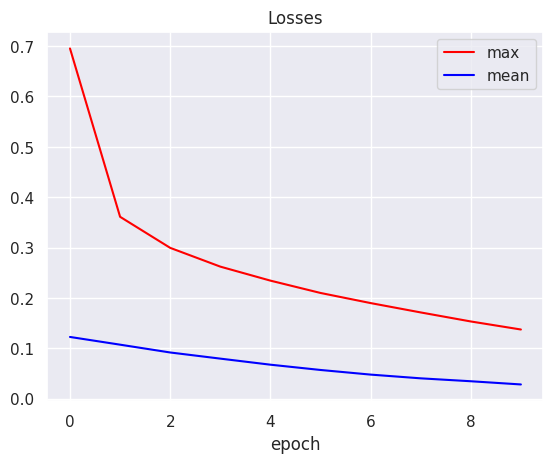

In [50]:
plot_metrics(losses_type, 'Losses')

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 90.06
Лучшая accuracy для подхода mean: 90.16


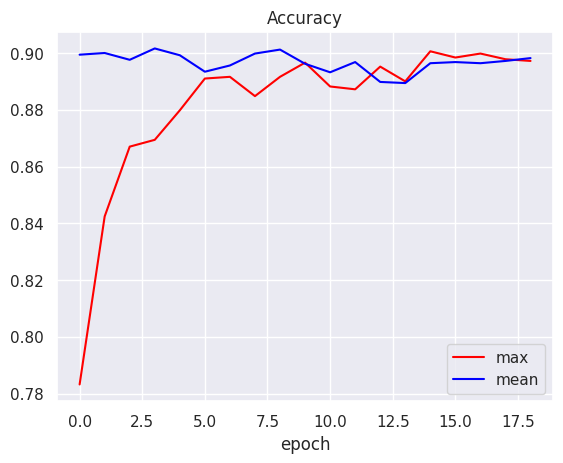

In [51]:
plot_metrics(acc_type, 'Accuracy')

In [52]:
torch.save(model.state_dict(), 'model_CharGRUx2.pth')

In [53]:
results.loc[2] = [
    'CharGRUx2', max(acc_type['mean']),
                   max(acc_type['max']),
                       float(evaluate(model, eval_dataloader))
                                         ]
results

,Model,Train_Accuracy_Mean,Train_Accuracy_Max,Accuracy_score
0,CharLM,0.8912,0.8966,0.8830
1,CharGRU,0.9020,0.8996,0.8986
2,CharGRUx2,0.9016,0.9006,0.8964


In [54]:
results.to_csv('results.csv')

In [55]:
del model

# Попробуем модель bidirectional RNN c num_layers=2 и 5 эпох

In [56]:
clear_vram()

In [57]:
model = CharLMx2(hidden_dim=256, vocab_size=len(vocab)).to(device)

In [58]:
losses_type, acc_type = train(num_epoch=10, model=model)

Starting training for max


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

Starting training for mean


Training epoch 10::   0%|          | 0/10 [00:00<?, ?it/s]

#### Отрисуем график loss

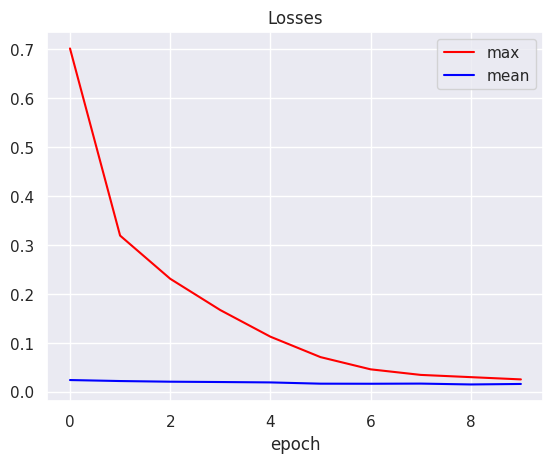

In [59]:
plot_metrics(losses_type, 'Losses')

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 89.92
Лучшая accuracy для подхода mean: 89.00


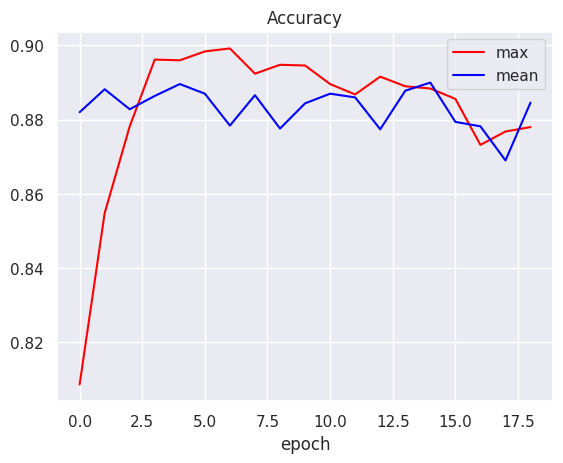

In [60]:
plot_metrics(acc_type, 'Accuracy')

In [61]:
torch.save(model.state_dict(), 'model_CharLMx2.pth')

In [63]:
results.loc[3] = [
    'CharLMx2', max(acc_type['mean']),
                   max(acc_type['max']),
                       float(evaluate(model, eval_dataloader))
                                         ]
results

,Model,Train_Accuracy_Mean,Train_Accuracy_Max,Accuracy_score
0,CharLM,0.8912,0.8966,0.8830
1,CharGRU,0.9020,0.8996,0.8986
2,CharGRUx2,0.9016,0.9006,0.8964
3,CharLMx2,0.8900,0.8992,0.8822


In [64]:
results.to_csv('results.csv')

In [65]:
del model

### Лучшая модель

In [67]:
best_model = results.loc[results['Accuracy_score'].idxmax(), 'Model']
print('Лучшая модель:', best_model, 'со скором:', max(results['Accuracy_score']))

Лучшая модель: CharGRU со скором: 0.8985999822616577


### Подитожим:
Базовая модель идет стабильно к увеличению скора, но до опредленного предела, максимальный скор 0,8966 на max, 0,8830 на evaluate.

Модель GRU c максимальным скором 0,9020 на mean, 0.8986 на evaluate.

Модель GRU с двумя слоями дала скор в 0,9016 на mean, 0.8964 на evaluate.

Модель bidirectional RNN с 2-мя слоями дала скор 0,8992 на max, 0.8822 на evaluate.

Базовая модель показала большую стабильность, но модели GRU дают неплохие результаты в скоре.

Оптимальная модель с моей точки зрения - GRU